In [2]:
import sys
## save variables
import pickle
## folder names
from glob import glob
## wav import
from scipy.io import wavfile 
## standard libraries
import numpy as np
## MFCC
#!{sys.executable} -m pip install msgpack --user
#!{sys.executable} -m pip install python_speech_features --user

from python_speech_features import mfcc
from python_speech_features import logfbank
from python_speech_features import delta

import random as rnd
import os.path
import tarfile

from six.moves import urllib

import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook
from scipy import signal
from scipy.io import wavfile


#!{sys.executable} -m pip install opencv-python --user
#!{sys.executable} -m pip install opencv-contrib-python --user
#import cv2
#garbage collector
import gc
#OS detection
import platform

In [3]:
#make variables directory if not present
dest_directory = 'variables/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)

        #data url from which download the dataset      
data_url = 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'

#make dataset directory if not present
dest_directory = 'dataset/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)

#select the last part of the dataurl (the file name)      
filename = data_url.split('/')[-1]
filepath = os.path.join(dest_directory, filename)

#program the download and extraction if the file doesn't exists
if not os.path.exists(filepath):
    def progress(count, block_size, total_size):
        sys.stdout.write(
            '\r>> Downloading %s %.1f%%' %
            (filename, float(count * block_size) / float(total_size) * 100.0))
        sys.stdout.flush()
    try:
        filepath, _ = urllib.request.urlretrieve(data_url, filepath, progress)
    except:
        print(Error)
        
    tarfile.open(filepath, 'r:gz').extractall(dest_directory)

In [4]:
## Return the word between two string starting from left
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

In [5]:
coreKey = ["Yes", "No", "Up", "Down", "Left", "Right", "On", "Off", "Stop", "Go", "Zero",
           "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine"]
sampleRate = 16000

In [6]:
#control if the raw data are saved with pickle
#if true they will be loaded in rawDict
reDo = False
if os.path.exists('variables/rawDict.pkl') and not reDo:
    print('rawDict found')
    with open('variables/rawDict.pkl', 'rb') as f:  
        rawDict = pickle.load(f)
    print('rawDict loaded')
#else they will be loaded from wav files
else:
    print('Creating rawDict')
    folders = glob("dataset/*/")
    folders.remove('dataset\\_background_noise_\\')
    print('SIGNALS')
    rawDict = {}
    for key in folders:
        print('Processing ', key)
        dictKey = find_between( key, '\\', '\\' )
        tmpFiles = glob(key+'*')
        array = []
        for file in tmpFiles:
            tmp = wavfile.read(file)[1].copy()
            #tmp = tmp.copy()
            #sampleRate.append(sampleRateTmp)
            tmp.resize(16000, refcheck=False)
            array.append(tmp)
        rawDict[dictKey] = np.array(array)
    #and saved with pickle
    with open('variables/rawDict.pkl', 'wb') as f:  
        pickle.dump(rawDict, f)
    print('rawDict created and saved to variables/rawDict.pkl')
reDo = True
#the same with noise signals
if not os.path.exists('variables/noiseDict.pkl') or reDo:    
    print('\nNOISE')
    noiseDict = {}
    folders = glob('dataset/_background_noise_/*.wav')
    for key in folders:
        print('Processing ', key)
        noiseDict[key[key.rindex('/')+1:len(key)]] = wavfile.read(key)[1]
    with open('variables/noiseDict.pkl', 'wb') as f:  
        pickle.dump(noiseDict, f) 
    print('noiseDict created and saved to variables/noiseDict.pkl')
else:
    print('noiseDict found')
    with open('variables/noiseDict.pkl', 'rb') as f:  
        noiseDict = pickle.load(f)
    print('noiseDict loaded')

rawDict found
rawDict loaded

NOISE
Processing  dataset/_background_noise_\doing_the_dishes.wav
Processing  dataset/_background_noise_\dude_miaowing.wav
Processing  dataset/_background_noise_\exercise_bike.wav
Processing  dataset/_background_noise_\pink_noise.wav
Processing  dataset/_background_noise_\running_tap.wav
Processing  dataset/_background_noise_\white_noise.wav
noiseDict created and saved to variables/noiseDict.pkl


C:\Users\yurin\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


# Shift

In [7]:
def shiftVec(signal, value):
    initial_length = signal.shape[0]
    padded = np.pad(signal, (abs(value),abs(value)), 'constant', constant_values=0)
    signal = padded[abs(value)-value:abs(value)+initial_length-value]
    return signal

In [8]:
shift_percentage = 0.1
time_shift_max = 100 #[ms]
sample_shift_max = round(time_shift_max / 1000 * sampleRate)
tot_samples = 0
for key in rawDict:
    length = rawDict[key].shape[0]
    tot_samples+=length
    toShift = round(length*shift_percentage)
    for i in rnd.sample(range(length),toShift):
        shift = rnd.randint(-sample_shift_max, sample_shift_max)
        rawDict[key][i] = shiftVec(rawDict[key][i],shift)        

# Noise

In [9]:
def noiseSelector(noise, nSample):
    length = len(noise)
    choice = rnd.randint(0, length-1)
    key = list(noise.keys())[choice]
    start = rnd.randint(0, noise[key].shape[0]-nSample-1)
    return noise[key][start:start+nSample]

In [10]:
rnd.seed(1)
noise_percentage = 0.1 
for key in rawDict:
    length = rawDict[key].shape[0]
    toNoise = round(length*noise_percentage)
    for i in rnd.sample(range(length),toNoise):
        noise = noiseSelector(noiseDict, 16000)
        rawDict[key][i] += np.array(np.round(np.random.uniform() * noise),dtype='int16')

# Silence creation

In [11]:
key = 'silence'
silence_percentage = 0.05
max_noise_sound = 0.2
silence_max = round(tot_samples*silence_percentage)
values = []
for i in range(silence_max):
    noise = noiseSelector(noiseDict, 16000)
    sig = noise * np.random.uniform(high = max_noise_sound)
    values.append(sig)
values = np.array(values)
rawDict[key]=values

In [14]:
values = [[14,26,0.025,0.01,512]]

# MFCC

\begin{verbatim}
Parameter         Description
signal 	          the audio signal from which to compute features. Should be an N*1 array
samplerate 	      the samplerate of the signal we are working with.
winlen 	          the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
winstep 	      the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
numcep 	          the number of cepstrum to return, default 13
nfilt 	          the number of filters in the filterbank, default 26.
nfft 	          the FFT size. Default is 512
lowfreq 	      lowest band edge of mel filters. In Hz, default is 0
highfreq 	      highest band edge of mel filters. In Hz, default is samplerate/2\\
preemph 	      apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97\\
ceplifter 	      apply a lifter to final cepstral coefficients. 0 is no lifter. Default is 22\\
appendEnergy 	  if this is true, the zeroth cepstral coefficient is replaced with the log of the total frame energy.\\
returns 	      A numpy array of size (NUMFRAMES by numcep) containing features. Each row holds 1 feature vector.\\
\end{verbatim}

In [12]:
from threading import Thread
import threading

from multiprocessing import Process

threadLock = threading.Lock()
def computeMFCC(data, output, i, sampleRate = 16000):
    for sig in data:
        mfcc_feat = mfcc(sig,sampleRate, numcep = i[0], nfilt = i[1], winlen = i[2], winstep = i[3], nfft = i[4])
        output.append(mfcc_feat)
def computeLogF(data, output, i, sampleRate = 16000):
    for sig in data:
        lfilt_feat = logfbank(sig,sampleRate, nfilt = i[1], winlen = i[2], winstep = i[3], nfft = i[4])
        output.append(lfilt_feat)
def computeDelta(mfccValues, N = 2):
    temp = []
    for count, _ in enumerate(mfccValues):
        delt = delta(mfccValues[count], N)
        temp.append(delt)
        #temp.append(np.hstack([mfccValues[count],delt]))
    return temp
        

<IPython.core.display.Javascript object>


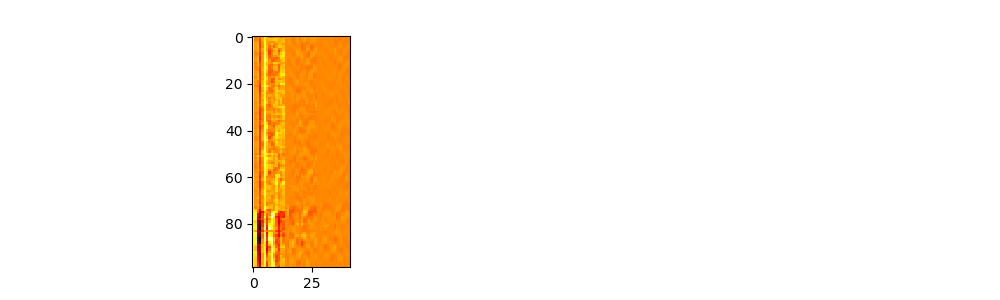


variables/mfccDict[nC=14 wL=0.025 wS=0.01].pkl not found
Processing  backward  ( 1 / 36 )
Processing  bed  ( 2 / 36 )
Processing  bird  ( 3 / 36 )
Processing  cat  ( 4 / 36 )
Processing  dog  ( 5 / 36 )
Processing  down  ( 6 / 36 )
Processing  eight  ( 7 / 36 )
Processing  five  ( 8 / 36 )
Processing  follow  ( 9 / 36 )
Processing  forward  ( 10 / 36 )
Processing  four  ( 11 / 36 )
Processing  go  ( 12 / 36 )
Processing  happy  ( 13 / 36 )
Processing  house  ( 14 / 36 )
Processing  learn  ( 15 / 36 )
Processing  left  ( 16 / 36 )
Processing  marvin  ( 17 / 36 )
Processing  nine  ( 18 / 36 )
Processing  no  ( 19 / 36 )
Processing  off  ( 20 / 36 )
Processing  on  ( 21 / 36 )
Processing  one  ( 22 / 36 )
Processing  right  ( 23 / 36 )
Processing  seven  ( 24 / 36 )
Processing  sheila  ( 25 / 36 )
Processing  six  ( 26 / 36 )
Processing  stop  ( 27 / 36 )
Processing  three  ( 28 / 36 )
Processing  tree  ( 29 / 36 )
Processing  two  ( 30 / 36 )
Processing  up  ( 31 / 36 )
Processing  visu

In [85]:
%%time
# list with mfcc parameters in order: [numcep, nfilt, winlen, winstep]
values = [[14,26,0.025,0.01,512]]
with open('variables/mfccValues.pkl', 'wb') as f:  
    pickle.dump(values, f)
reDo = True

plt.figure(2,figsize=(10,3))
#look for the already computed mfcc
for count, i in enumerate(values):
    name = 'variables/mfccDict[nC='+str(i[0])+' wL='+str(i[2])+' wS='+str(i[3])+'].pkl'
    if os.path.exists(name) and not reDo:
        print('\n'+name+' found')
        with open(name, 'rb') as f:  
            mfccDict = pickle.load(f)
        plt.subplot(round(len(values)/2)+1, 2, count+1)
        plt.imshow(mfccDict['one'][0], cmap='hot', interpolation='nearest')
    else:
        print('\n'+name+' not found')
        mfccDict = {}
        for countKey, key in enumerate(rawDict):
            print('Processing ',key, " (", countKey+1, "/", len(rawDict),")" )
            array = []
            '''
            jobs = []
            tot = 1
            interval = rawDict[key].shape[0]/tot
            for div in range(tot):
                jobs.append(Thread( target=computeMFCC, args=(rawDict[key][int(interval*(div)):int(interval*(div+1))], array, i) ))
            for th in jobs:
                th.start()
            for th in jobs:
                th.join()
            
            '''
            computeMFCC(rawDict[key], array, i)            
            mfccDict[key] = np.array(array)
        with open('variables/mfccDict[nC='+str(i[0])+' wL='+str(i[2])+' wS='+str(i[3])+'].pkl', 'wb') as f:  
            pickle.dump(mfccDict, f)
        print("process delta and delta-delta")
        for countKey, key in enumerate(mfccDict):
            print('Processing ',key, " (", countKey+1, "/", len(mfccDict),")" )
            delt = np.array(computeDelta(mfccDict[key]))
            deltdelt = np.array(computeDelta(delt))
            mfccDict[key] = np.stack([mfccDict[key],delt,deltdelt], axis = -1)
        with open('variables/mfcc_D_DD_Dict[nC='+str(i[0])+' wL='+str(i[2])+' wS='+str(i[3])+'].pkl', 'wb') as f:  
            pickle.dump(mfccDict, f)
        plt.subplot(round(len(values)/2)+1, 2, count+1)
        plt.imshow(mfccDict['backward'][0], cmap='hot', interpolation='nearest')
plt.show()

# LogFilter with delta


In [21]:
%%time
for count, i in enumerate(values):
    name = 'variables/logfiltDict[nF='+str(i[1])+' wL='+str(i[2])+' wS='+str(i[3])+'].pkl'
    print('Computing '+name)
    logFDict = {}
    for countKey, key in enumerate(rawDict):
        print('Processing ',key, " (", countKey+1, "/", len(rawDict),")" )
        array = []
        '''
        jobs = []
        tot = 1
        interval = rawDict[key].shape[0]/tot
        for div in range(tot):
            jobs.append(Thread( target=computeMFCC, args=(rawDict[key][int(interval*(div)):int(interval*(div+1))], array, i) ))
        for th in jobs:
            th.start()
        for th in jobs:
            th.join()

        '''
        computeLogF(rawDict[key], array, i)            
        logFDict[key] = np.array(array)
    print("process delta and delta-delta")
    for countKey, key in enumerate(logFDict):
        print('Processing ',key, " (", countKey+1, "/", len(logFDict),")" )
        delt = np.array(computeDelta(logFDict[key]))
        deltdelt = np.array(computeDelta(delt))
        logFDict[key] = np.stack([logFDict[key],delt,deltdelt], axis = -1)
    with open(name, 'wb') as f:  
        pickle.dump(logFDict, f)

Computing variables/logfiltDict[nF=26 wL=0.025 wS=0.01].pkl
Processing  backward  ( 1 / 36 )
Processing  bed  ( 2 / 36 )
Processing  bird  ( 3 / 36 )
Processing  cat  ( 4 / 36 )
Processing  dog  ( 5 / 36 )
Processing  down  ( 6 / 36 )
Processing  eight  ( 7 / 36 )
Processing  five  ( 8 / 36 )
Processing  follow  ( 9 / 36 )
Processing  forward  ( 10 / 36 )
Processing  four  ( 11 / 36 )
Processing  go  ( 12 / 36 )
Processing  happy  ( 13 / 36 )
Processing  house  ( 14 / 36 )
Processing  learn  ( 15 / 36 )
Processing  left  ( 16 / 36 )
Processing  marvin  ( 17 / 36 )
Processing  nine  ( 18 / 36 )
Processing  no  ( 19 / 36 )
Processing  off  ( 20 / 36 )
Processing  on  ( 21 / 36 )
Processing  one  ( 22 / 36 )
Processing  right  ( 23 / 36 )
Processing  seven  ( 24 / 36 )
Processing  sheila  ( 25 / 36 )
Processing  six  ( 26 / 36 )
Processing  stop  ( 27 / 36 )
Processing  three  ( 28 / 36 )
Processing  tree  ( 29 / 36 )
Processing  two  ( 30 / 36 )
Processing  up  ( 31 / 36 )
Processing  vi

In [20]:
logFDict['backward'].shape

(1664, 99, 26, 3)